# Simulating Reliance stock price dynamics using Geometric brownian motion

In [1]:
pip install nsepy

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade git+https://github.com/StreamAlpha/pynse.git


  Cloning https://github.com/StreamAlpha/pynse.git to c:\users\gopal\appdata\local\temp\pip-req-build-tnvgo_v6
Note: you may need to restart the kernel to use updated packages.


  Running command git clone -q https://github.com/StreamAlpha/pynse.git 'C:\Users\gopal\AppData\Local\Temp\pip-req-build-tnvgo_v6'


In [3]:
import pandas as pd
import numpy as np

In [4]:
from pynse import *
import datetime as dt
import logging
logging.basicConfig(level=logging.DEBUG)


nse=Nse()
print(nse)

INFO:pynse.core:pyNse cache size: (7.09, 'MB').
You may want to run `nse.clear_data()` if running low on disk space.


In [14]:
df=nse.get_hist('RELIANCE',from_date=dt.date(2021,1,1),to_date=dt.date(2022,4,21))
df.head()

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): www.nseindia.com:443
DEBUG:urllib3.connectionpool:https://www.nseindia.com:443 "GET / HTTP/1.1" 200 40257
DEBUG:urllib3.connectionpool:https://www.nseindia.com:443 "GET /api/historical/cm/equity?symbol=RELIANCE&series=%5B%22EQ%22%5D&from=01-01-2021&to=21-04-2022&csv=true HTTP/1.1" 200 14568


,open,high,low,close,volume
Date,,,,,
2021-01-01,1988.0,1997.0,1982.00,1987.50,4622002
2021-01-04,1995.1,1998.9,1968.00,1990.85,11312992
2021-01-05,1969.0,1983.6,1956.00,1966.10,11132803
2021-01-06,1965.9,1966.0,1905.15,1914.25,21414270
2021-01-07,1920.5,1945.0,1905.15,1911.15,14918406


In [15]:
import matplotlib.pyplot as plt

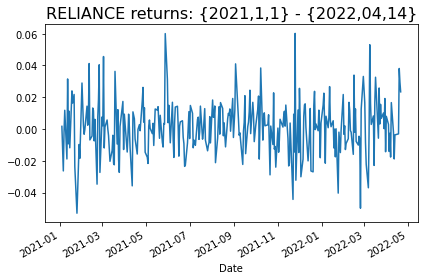

Average return: 0.12%


In [16]:
adj_close = df['close']
returns = adj_close.pct_change().dropna()

ax = returns.plot()
ax.set_title( 'RELIANCE returns: {2021,1,1} - {2022,04,14}', 
             fontsize=16)

plt.tight_layout()
plt.show()

print(f'Average return: {100 * returns.mean():.2f}%')

In [17]:
train = returns['2021-01-01':'2021-08-31']
test = returns['2021-09-01':'2022-04-21']

In [18]:
T = len(test)
N = len(test)
s_0 = adj_close[train.index[-1]]
N_SIM = 100
mu = train.mean()
sigma = train.std()

In [19]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, 
                random_seed=42):
    '''
    Function used for simulating stock returns using Geometric Brownian Motion.
    
    Parameters
    ------------
    s_0 : float
    Initial stock price
    mu : float
    Drift coefficient
    sigma : float
    Diffusion coefficient
    n_sims : int
    Number of simulations paths
    dt : float
    Time increment, most commonly a day
    T : float
    Length of the forecast horizon, same unit as dt
    N : int
    Number of time increments in the forecast horizon
    random_seed : int
    Random seed for reproducibility
    
    Returns
    -----------
    S_t : np.ndarray
    Matrix (size: n_sims x (T+1)) containing the simulation results. 
    Rows respresent sample paths, while columns point of time.
    '''''
    np.random.seed(random_seed)
    
    dt = T/N
    dW = np.random.normal(scale = np.sqrt(dt), size=(n_sims, N))
    W = np.cumsum(dW, axis=1)
    
    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))
    
    S_t = s_0 * np.exp((mu - 0.5 * sigma**2) * time_steps 
                      + sigma * W)
    S_t = np.insert(S_t, 0, s_0, axis=1)
    
    return S_t

In [20]:
gbm_simulations = simulate_gbm(s_0, mu, sigma, N_SIM, T, N)

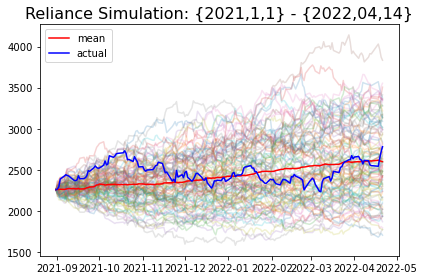

In [22]:
# prepare objects for plotting 
last_train_date = train.index[-1].date()
first_test_date = test.index[0].date()
last_test_date = test.index[-1].date()
plot_title = ('Reliance Simulation: {2021,1,1} - {2022,04,14}')

selected_indices = adj_close[last_train_date:last_test_date].index
index = [date.date() for date in selected_indices]

gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations), 
                                 index=index)

# plotting
ax = gbm_simulations_df.plot(alpha=0.2, legend=False)
line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1), 
                 color='red')
line_2, = ax.plot(index, adj_close[last_train_date:last_test_date], 
                 color='blue')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1, line_2), ('mean', 'actual'))

plt.tight_layout()
plt.show()